In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

import geopandas as gpd
from geodatasets import get_path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from create_dataframe import fetch_world_df

In [ ]:
def silhouette_method_ts(seed, X):
    # Calculate the silhouette score
    for n in range(2, 11):
        # Initialize the clusterer with n_clusters value and a random generator
        ks = (TimeSeriesKMeans(n_clusters=n, 
                               metric="euclidean",
                               max_iter=5, 
                               verbose=False,
                               random_state=seed)
                         .fit(X))
        # Shape data into a 2D array
        temp_df, col2, col3 = X.shape
        two_d_data = X.reshape((temp_df, col2*col3))
        
        # Get cluster labels
        cluster_labels = ks.fit_predict(two_d_data)
        silhouette_avg = silhouette_score(two_d_data, cluster_labels)
        print(
            "For n_clusters =",
            n,
            "The average silhouette_score is :",
            silhouette_avg,
        )

In [ ]:
def elbow_method_ts(seed, X):
    # Calculate the best k value using elbow method
    distortions = []
    
    # Calculated from 1~10 clusters
    for i  in range(1,11):
        ks = (TimeSeriesKMeans(n_clusters=i, 
                              metric="euclidean", 
                              max_iter=5, 
                              random_state=seed)
              .fit(X))
        # ks.fit gives ks.inertia_
        distortions.append(ks.inertia_)
    
    plt.plot(range(1,11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

Information from:
- https://github.com/tslearn-team/tslearn/
- https://tslearn.readthedocs.io/en/stable/installation.html
- https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py
- https://levelup.gitconnected.com/unveiling-patterns-in-time-a-guide-to-time-series-clustering-with-tslearn-50a2ff305afe

IMPORTANT: To get tslearn to work you need numpy to be on version 1.21.0 and Python 3.9.16 !!!
- This is because of a error that has not been corrected by tslearn where it uses 'typeDict' instead of 'sctypeDict'
- It might be worth exploring installing it like this: python -m pip install https://github.com/tslearn-team/tslearn/archive/main.zip
- However, I am using tslearn 0.6.3 which still required this hoops to jump through

In [63]:
from create_dataframe import fetch_country_df, fetch_climate_df

country_df = fetch_country_df()
climate_df = fetch_climate_df()

# Create the global dataset by merging the two dataframes, putting the Country column first so it is easier to read
# The "WLD" column is dropped here
global_df = country_df.merge(climate_df, on='ISO3').drop(['ObjectId', 'id'], axis=1)
global_df.head()

,name,ISO3,capital,region,subregion,timezones,latitude,longitude,emoji,emojiU,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,afghanistan,AFG,Kabul,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0,🇦🇫,U+1F1E6 U+1F1EB,...,1.281,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012
1,albania,ALB,Tirana,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0,🇦🇱,U+1F1E6 U+1F1F1,...,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518
2,algeria,DZA,Algiers,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0,🇩🇿,U+1F1E9 U+1F1FF,...,1.192,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688
3,american samoa,ASM,Pago Pago,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0,🇦🇸,U+1F1E6 U+1F1F8,...,1.257,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256
4,andorra,AND,Andorra la Vella,Europe,Southern Europe,"[{zoneName:'Europe\/Andorra',gmtOffset:3600,gm...",42.500000,1.5,🇦🇩,U+1F1E6 U+1F1E9,...,0.831,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243


In [ ]:
# Get a list of the country names and then transpost the climate data
country_name = global_df.iloc[:, 1:2]
climate_data = global_df.iloc[:, 10:-1]

# Way to transpose the dataframe if needed
# frames = [country_name, climate_data]
# df = pd.concat(frames)

In [64]:
seed = 0
np.random.seed(seed)

# Create a test and training dataset with a % split for our testing data
# Normalize our training data
X_train, X_test = train_test_split(climate_data, test_size=0.2, random_state=seed)
X_train = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(X_test)

In [ ]:
# Resample our data to reduce computation time
# I am leaving this commented out for the moment as it HEAVILY effects results
# X_resampled = TimeSeriesResampler(sz=40).fit_transform(X_train)

In [65]:
silhouette_method_ts(seed, X_train)

For n_clusters = 2 The average silhouette_score is : 0.12347787565915795
For n_clusters = 3 The average silhouette_score is : 0.12497439793330743
For n_clusters = 4 The average silhouette_score is : 0.08758984974392425
For n_clusters = 5 The average silhouette_score is : 0.10889772474374737
For n_clusters = 6 The average silhouette_score is : 0.0758343041958606
For n_clusters = 7 The average silhouette_score is : 0.08306504915338497
For n_clusters = 8 The average silhouette_score is : 0.11522416449437506
For n_clusters = 9 The average silhouette_score is : 0.11283472171644296
For n_clusters = 10 The average silhouette_score is : 0.11835612777956767


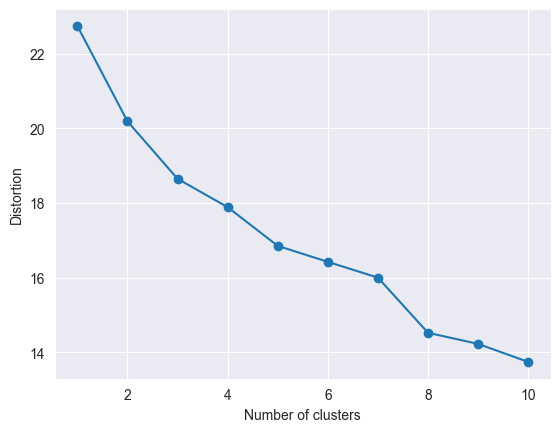

In [66]:
elbow_method_ts(seed, X_train)

In [67]:
num_of_clusters = 3

Init 1
27.367 --> 19.211 --> 18.828 --> 18.711 --> 18.648 --> 
Init 2
31.039 --> 18.711 --> 18.428 --> 18.371 --> 18.361 --> 
Init 3
30.797 --> 19.428 --> 18.998 --> 18.742 --> 18.680 --> 
Init 4
26.999 --> 19.234 --> 18.952 --> 18.765 --> 18.481 --> 
Init 5
30.578 --> 19.392 --> 18.834 --> 18.623 --> 18.566 --> 
Init 1
27.367 --> 19.211 --> 18.828 --> 18.711 --> 18.648 --> 
Init 2
31.039 --> 18.711 --> 18.428 --> 18.371 --> 18.361 --> 
Init 3
30.797 --> 19.428 --> 18.998 --> 18.742 --> 18.680 --> 
Init 4
26.999 --> 19.234 --> 18.952 --> 18.765 --> 18.481 --> 
Init 5
30.578 --> 19.392 --> 18.834 --> 18.623 --> 18.566 --> 
Init 1
27.367 --> 19.211 --> 18.828 --> 18.711 --> 18.648 --> 
Init 2
31.039 --> 18.711 --> 18.428 --> 18.371 --> 18.361 --> 
Init 3
30.797 --> 19.428 --> 18.998 --> 18.742 --> 18.680 --> 
Init 4
26.999 --> 19.234 --> 18.952 --> 18.765 --> 18.481 --> 
Init 5
30.578 --> 19.392 --> 18.834 --> 18.623 --> 18.566 --> 
Silhouette Score: 0.13202172081729385


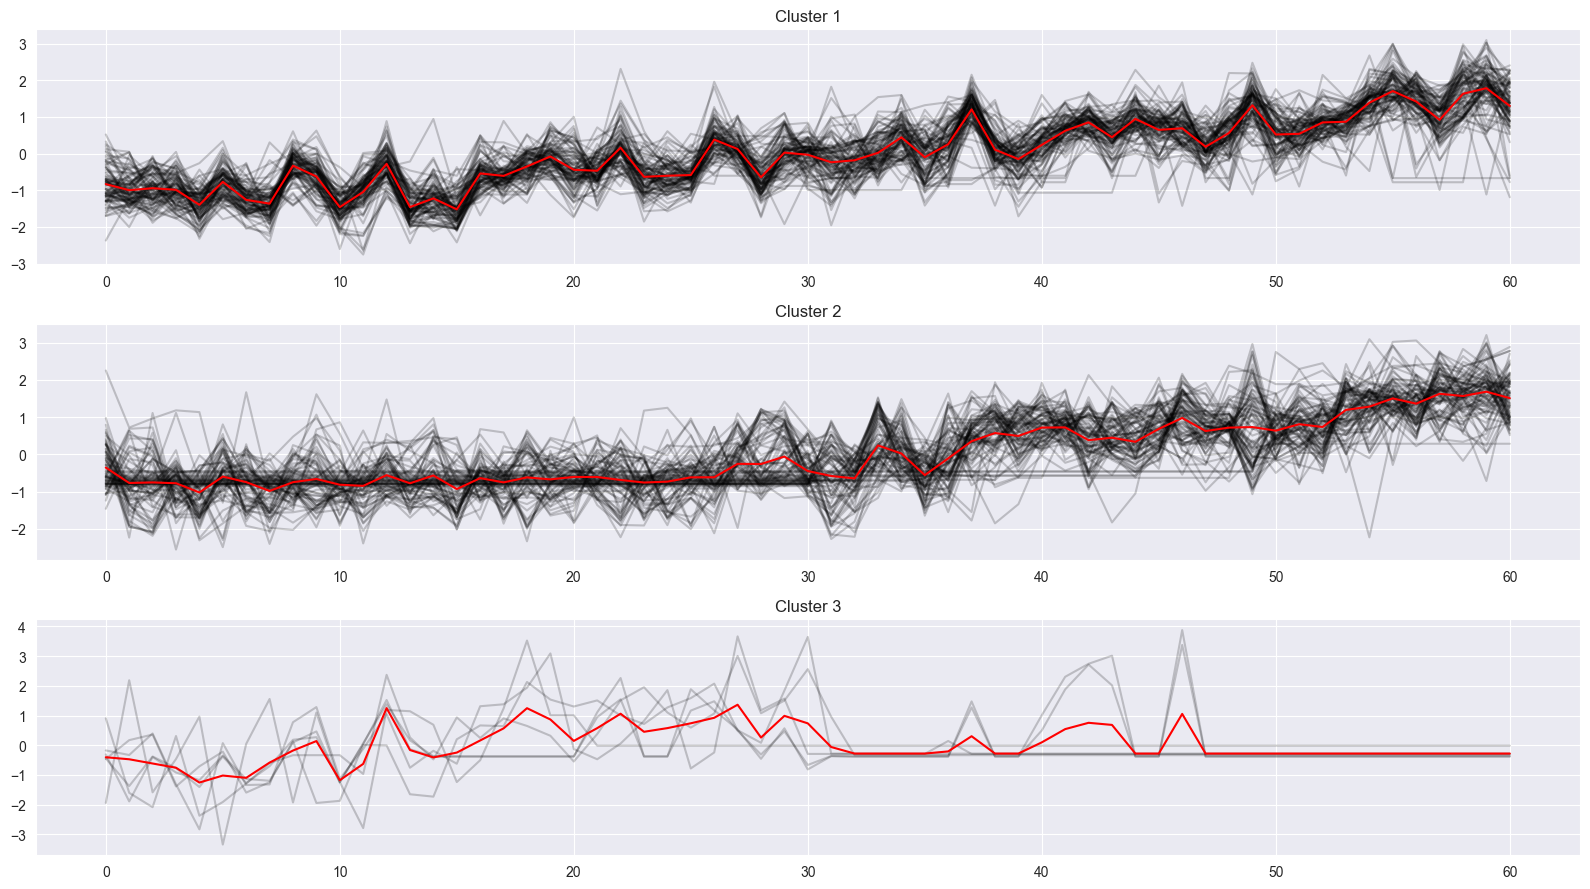

In [70]:
# Create K-Means Model using TimeSeriesKMeans
# https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html
# Verbose = True, prints out infom
k_means_model = (TimeSeriesKMeans(n_clusters=num_of_clusters,
                                  metric="euclidean",
                                  max_iter=5,
                                  n_init=5,
                                  verbose=True,
                                  random_state=seed).fit(X_train))
y_pred = k_means_model.fit_predict(X_train)

# Shape data into a 2D array
temp_df, col2, col3 = X_train.shape
two_d_data = X_train.reshape((temp_df, col2*col3))

# Get cluster labels
cluster_labels = k_means_model.fit_predict(two_d_data)
silhouette_avg = silhouette_score(two_d_data, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Visualizing the clustering results
plt.figure(figsize=(16, 9))
for yi in range(num_of_clusters):
    plt.subplot(num_of_clusters, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(k_means_model.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [82]:
df_results, df_train = train_test_split(global_df, test_size=0.2, random_state=42)
df_results.insert(0, "kmeans_cluster", cluster_labels)
# df_results[df_results['kmeans_cluster'] == 2].shape
df_results.shape

(179, 73)

In [81]:
df_results_map = df_results.merge(fetch_world_df(), on='ISO3', indicator=False, how='outer')
df_results_map = df_results_map[df_results_map['kmeans_cluster'].notna()]
df_results_map = df_results_map[df_results_map['geometry'].notna()]
df_results_map.shape

(134, 78)

In [83]:
df_results_map = df_results_map[['kmeans_cluster', 'ISO3', 'geometry']].copy()

map_df = gpd.GeoDataFrame(
    df_results_map, crs="EPSG:4326"
)
type(map_df)

geopandas.geodataframe.GeoDataFrame

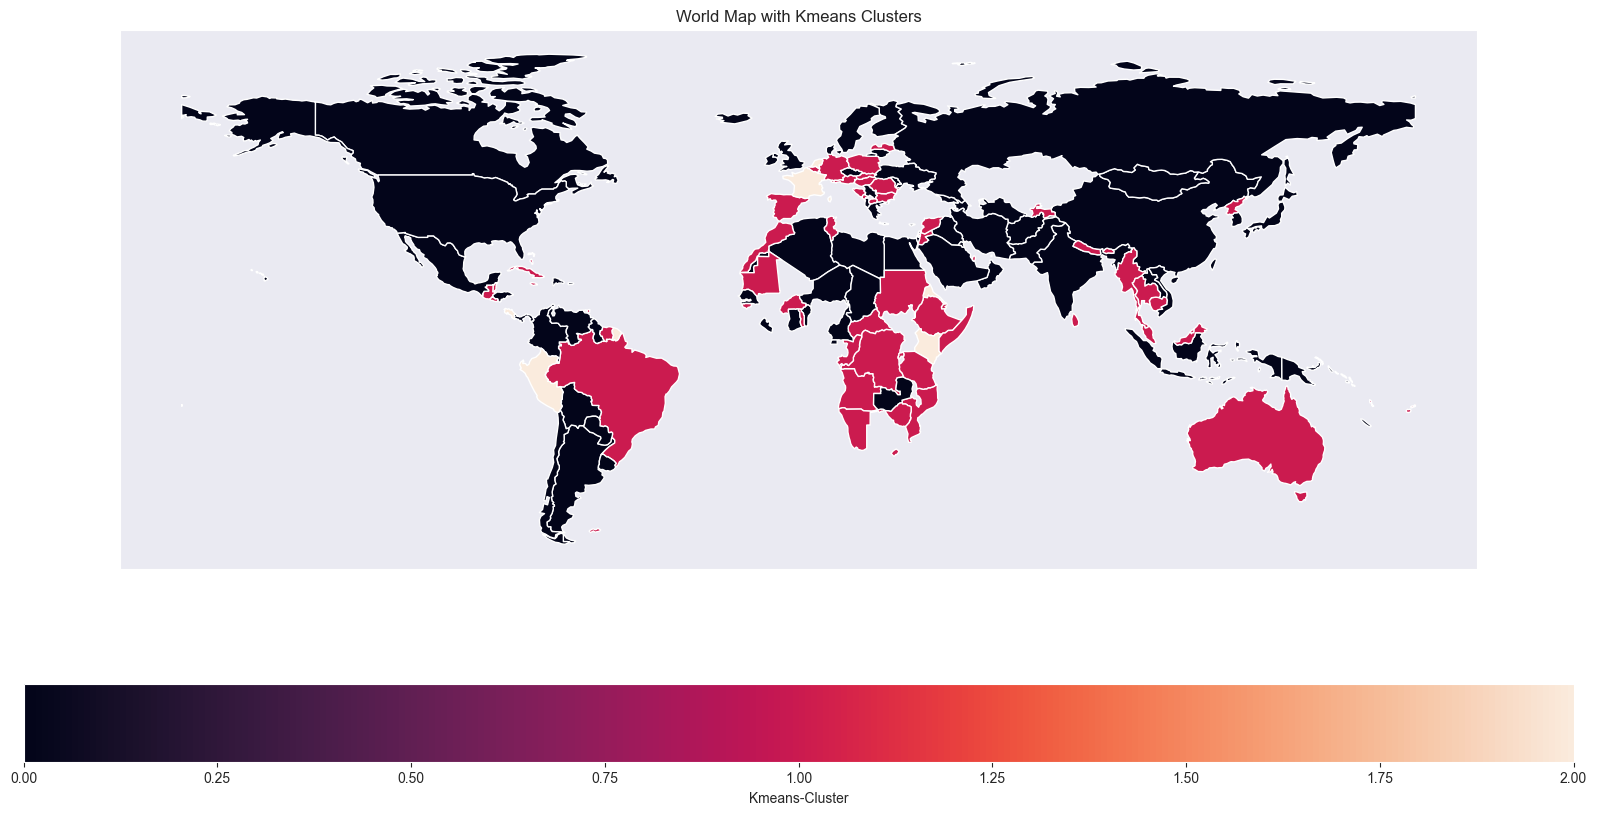

In [84]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

map_df.plot(
    column='kmeans_cluster', 
    ax=ax,
    legend=True,
    # cax=cax,
    legend_kwds={"label": "Kmeans-Cluster", "orientation": "horizontal"}
)

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# set the plot title
plt.title("World Map with Kmeans Clusters")
plt.show()

In [ ]:
# DBA-k-means
print("DBA k-means")
# dba_km = TimeSeriesKMeans(n_clusters=3,
#                           n_init=2,
#                           metric="dtw",
#                           verbose=True,
#                           max_iter_barycenter=10,
#                           random_state=seed)
# y_pred = dba_km.fit_predict(X_train)

# for yi in range(3):
#     plt.subplot(3, 3, 4 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("DBA $k$-means")

In [ ]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
# sdtw_km = TimeSeriesKMeans(n_clusters=3,
#                            metric="softdtw",
#                            metric_params={"gamma": .01},
#                            verbose=True,
#                            random_state=seed)
# y_pred = sdtw_km.fit_predict(X_train)
# 
# for yi in range(3):
#     plt.subplot(3, 3, 7 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("Soft-DTW $k$-means")
# plt.tight_layout()
# plt.show()